In [1]:
#read the data and intialize features (X) and responses (Y)
data = as.matrix(read.csv("tabular-data/large_protein_df.csv", header=T))
id = data[,-1]
X = apply(data[,-c(1,230)], 2, as.numeric)
Y = as.numeric(data[,230])

In [2]:
#randomly sample for training data
samp = sample(nrow(data), 0.7*nrow(data))
train.X = X[samp,]
test.X = X[-samp,]
train.Y = Y[samp]
test.Y = Y[-samp]

# Linear models

We'll reduce dimension by PCA and fit linear models.

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC219,PC220,PC221,PC222,PC223,PC224,PC225,PC226,PC227,PC228
Standard deviation,12939.83968,5960.88130,1377.56220,179.61471,170.34336,115.62927,77.95812,30.81464,27.38168,24.64422,⋯,1.021753e-12,1.021753e-12,5.144058e-13,3.406114e-13,8.397847e-14,9.723773e-15,6.150557e-15,1.536073e-15,5.605351e-16,5.573461e-16
Proportion of Variance,0.81696,0.17337,0.00926,0.00016,0.00014,0.00007,0.00003,0.00000,0.00000,0.00000,⋯,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Cumulative Proportion,0.81696,0.99032,0.99958,0.99974,0.99988,0.99995,0.99998,0.99998,0.99998,0.99999,⋯,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


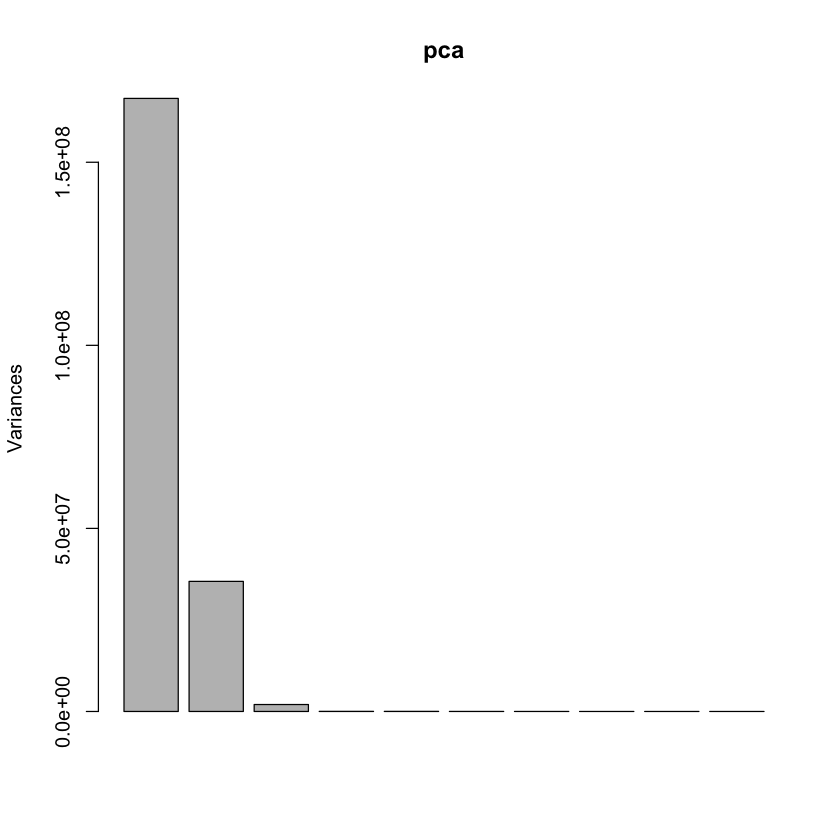

In [3]:
#do a PCA on the training data feature space
library(ggplot2)
library(factoextra)
pca <- prcomp(train.X, center = TRUE, retx = T)
plot(pca)
summary(pca)$importance

The first three principal components constitute $99.95\%$ of the variance. So we take the first three principal components and project our feature space onto these three coordinates and do linear regression.

In [4]:
num = 3 #number of top components we want to take from PCA (so, reduced dimension)
train_new = scale(train.X, pca$center, pca$scale) %*% pca$rotation [,1:num] #transfering the training data to the PCA axes
test_new = scale(test.X, pca$center, pca$scale) %*% pca$rotation [,1:num] #transfering the testing data to the PCA axes
lr.fit <- lm(train.Y ~ train_new) #fitting a linear model on the new feature-response data

prediction_test <- round(cbind(1, test_new) %*% lr.fit$coef,0) #make prediction on testing data and round it to get 0/1
prediction_train <- round(cbind(1, train_new) %*% lr.fit$coef,0) #make prediction on training data and round it to get 0/1 (for purposes of training error)
errortest.lr <- mean(prediction_test != test.Y)*100 #obtain testing error
errortrain.lr <- mean(prediction_train != train.Y)*100 #obtain training error
error <- matrix(c(100-errortest.lr, 100-errortrain.lr), ncol = 2) #tabularize accuracy rate
colnames(error) <- c("Test accuracy(%)", "Train accuracy(%)")
rownames(error) <- c("Linear Regression")
print(error)

                  Test accuracy(%) Train accuracy(%)
Linear Regression          75.1503          76.66094


The above linear regression is not much meaningful in the sense that we analyzed the data using features (i.e., principal components) that don't have meaning with respect to proteins.

So we look at which features (from the original data) that contribute most to the top three principal components. These turn out to be the features corresponding to columns `N`, `C`, `O`, `H`, `P`, `LEU`, `sing`. So columns $2,4,8,9,10,60,227$, as shown below.

In [5]:
print(which(pca$rotation[,1]>0.05))
cat('\n')
print(which(pca$rotation[,2]>0.05))
cat('\n')
print(which(pca$rotation[,2]>0.005))

N C O H 
2 4 8 9 

N C O 
2 4 8 

 N  C  O  P 
 2  4  8 10 


Then we focus only on the abovementioned features (columns) in `X`.

In [6]:
#restricting to the main columns and fitting a linear model
sub = c(2,4,8,9,10,60,227)
lr.fit1 <- lm(train.Y ~ train.X[,sub])
lr.fit1$coef

(Intercept)    train.X[, sub]N    train.X[, sub]C    train.X[, sub]O 
      2.160999e-01       3.455211e-05       2.693107e-06      -4.055130e-05 
   train.X[, sub]H    train.X[, sub]P  train.X[, sub]LEU train.X[, sub]sing 
     -3.798116e-06       8.122222e-05      -2.319907e-04       1.236459e-04

In [7]:
#predicting from this linear model
prediction_test1 <- round(cbind(1, test.X[,sub]) %*% lr.fit1$coef,0)
prediction_train1 <- round(cbind(1, train.X[,sub]) %*% lr.fit1$coef,0)
errortest.lr1 <- mean(prediction_test1 != test.Y)*100
errortrain.lr1 <- mean(prediction_train1 != train.Y)*100

In [8]:
#tabulating errors
error <- matrix(c(100-errortest.lr1, 100-errortrain.lr1), ncol = 2)
colnames(error) <- c("Test Acuracy(%)", "Train Accuracy(%)")
rownames(error) <- c("Linear Regression")
print(error)

                  Test Acuracy(%) Train Accuracy(%)
Linear Regression         75.0835          76.66094


# Tree-based method

We'll use the `tree` function in `R` to predict using regression trees.


## With all features

In [9]:
library(tree)
library(rpart)
dat = as.data.frame(cbind(X,Y))
j = ncol(dat)
dat.train = dat[samp,]
dat.test = dat[-samp,]

Testing error 88.30995 %
Training error 88.4307 %


Regression tree:
tree(formula = Y ~ ., data = dat.train)
Variables actually used in tree construction:
[1] "OLIG_COUNT" "SER"        "P"          "CYS"       
Number of terminal nodes:  6 
Residual mean deviance:  0.09109 = 317.5 / 3486 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.739500 -0.136600 -0.001413  0.000000 -0.001413  0.998600 

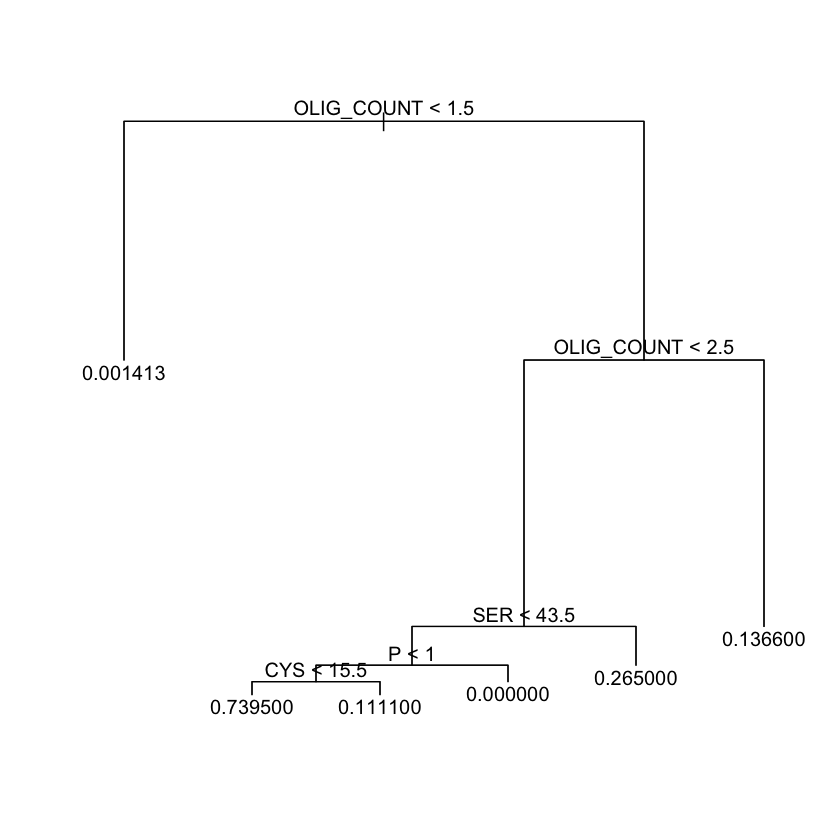

In [10]:
prot.tree = tree(Y ~ ., dat.train)
cat('Testing error', 100*sum(round(predict(prot.tree, dat.test),0)==dat.test[j])/nrow(dat.test), '%\n')
cat('Training error', 100*sum(round(predict(prot.tree, dat.train),0)==dat.train[j])/nrow(dat.train), '%')
summary(prot.tree)
plot(prot.tree)
text(prot.tree, cex = 1)

Let's use cross-validation to obtain optimal tree-size.

Size corresponding to minimum deviance by cross-validation: 6

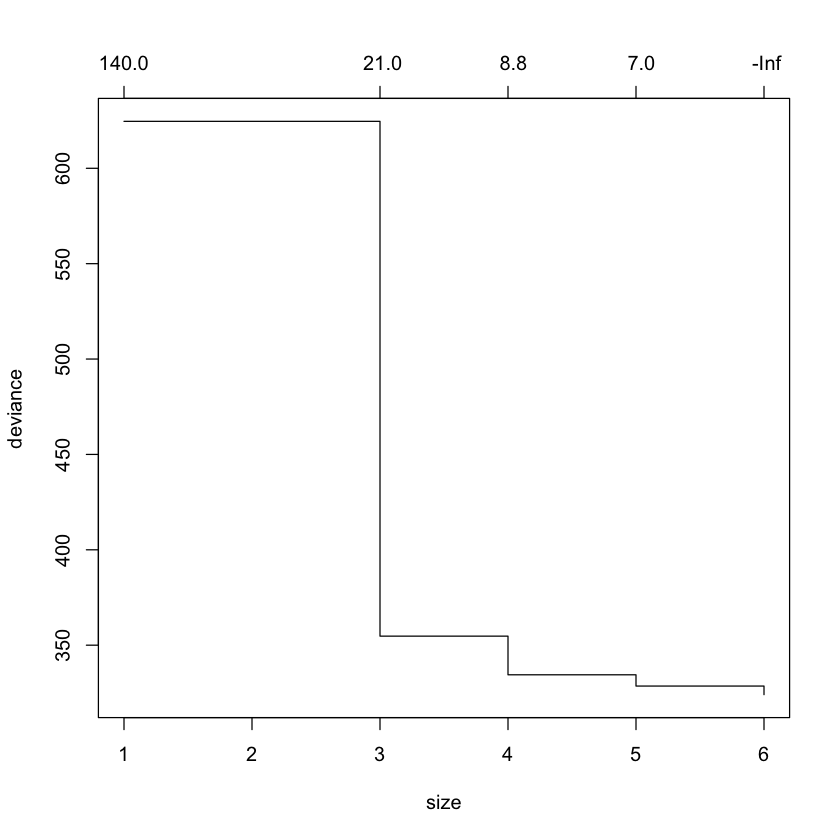

In [11]:
prot.cvtree = cv.tree(prot.tree) 
plot(prot.cvtree)
cat("Size corresponding to minimum deviance by cross-validation:", prot.cvtree$size[which.min(prot.cvtree$dev)])

Let's prune the tree to $3$ terminal nodes.

Testing error 87.50835 %
Training error 87.54296 %


Regression tree:
snip.tree(tree = prot.tree, nodes = 12L)
Variables actually used in tree construction:
[1] "OLIG_COUNT" "SER"       
Number of terminal nodes:  4 
Residual mean deviance:  0.09555 = 333.3 / 3488 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.712700 -0.136600 -0.001413  0.000000 -0.001413  0.998600 

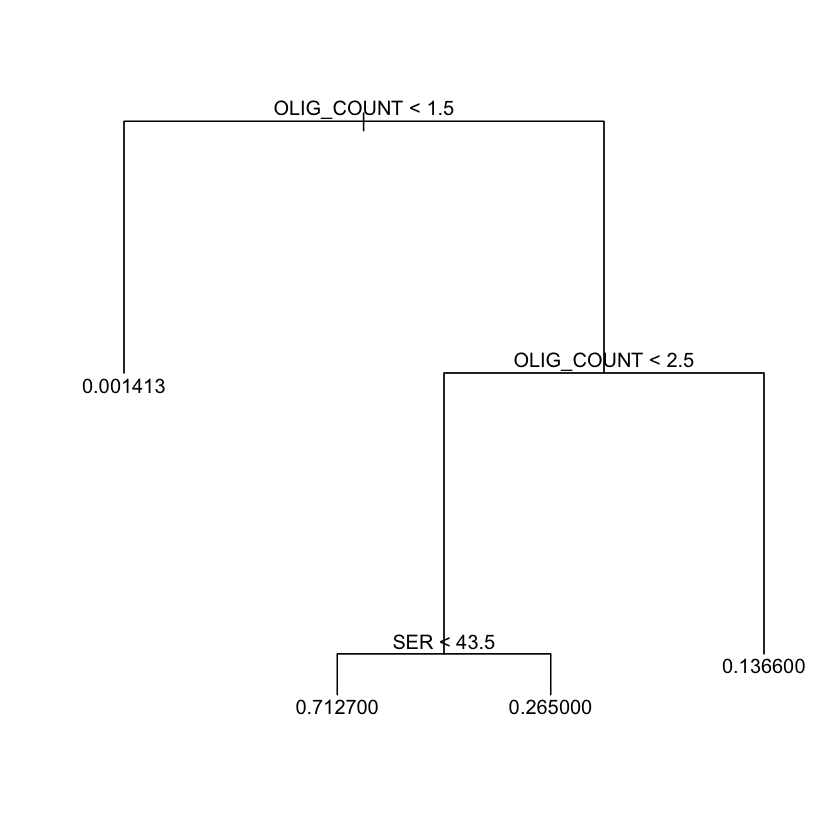

In [12]:
prot.pruned_tree =  prune.tree(prot.tree, best = 4)
cat('Testing error', 100*sum(round(predict(prot.pruned_tree, dat.test),0)==dat.test[j])/nrow(dat.test), '%\n')
cat('Training error', 100*sum(round(predict(prot.pruned_tree, dat.train),0)==dat.train[j])/nrow(dat.train), '%')
summary(prot.pruned_tree)
plot(prot.pruned_tree)
text(prot.pruned_tree)

There is a slight reduction of accuracy on pruning the tree.

## Without `OLIG_COUNT`

It seems like `OLIG_COUNT` is the most important feature above. Let's remove this feature and do the above analysis again.

In [13]:
dat = as.data.frame(cbind(X[,-c(228)],Y)) #removing column 228 which is OLIG_COUNT
j = ncol(dat)
dat.train = dat[samp,]
dat.test = dat[-samp,]

Testing error 75.1503 %
Testing error 76.68958 %


Regression tree:
tree(formula = Y ~ ., data = dat.train)
Variables actually used in tree construction:
[1] "SER" "H"  
Number of terminal nodes:  3 
Residual mean deviance:  0.1736 = 605.8 / 3489 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.2783 -0.2783 -0.2783  0.0000 -0.1041  0.8959 

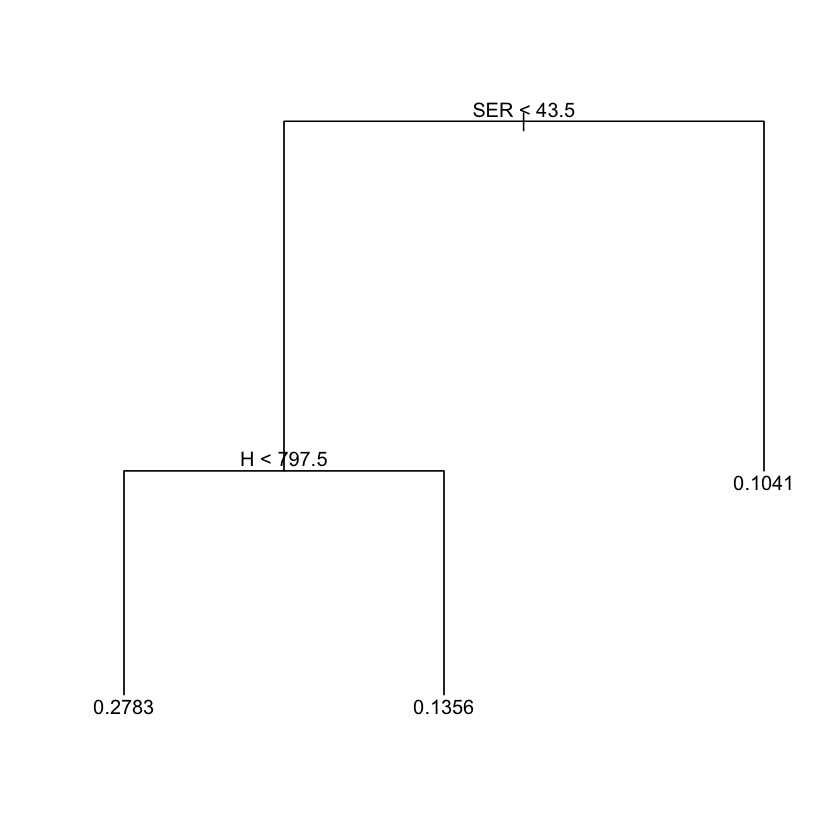

In [14]:
prot.tree = tree(Y ~ ., dat.train)
cat('Testing error', 100*sum(round(predict(prot.tree, dat.test),0)==dat.test[j])/nrow(dat.test), '%\n')
cat('Testing error', 100*sum(round(predict(prot.tree, dat.train),0)==dat.train[j])/nrow(dat.train), '%')
summary(prot.tree)
plot(prot.tree)
text(prot.tree, cex = 1)

In [15]:
sum(round(predict(prot.tree, dat.test),0))

[1] 0

Size corresponding to minimum deviance by cross-validation: 3

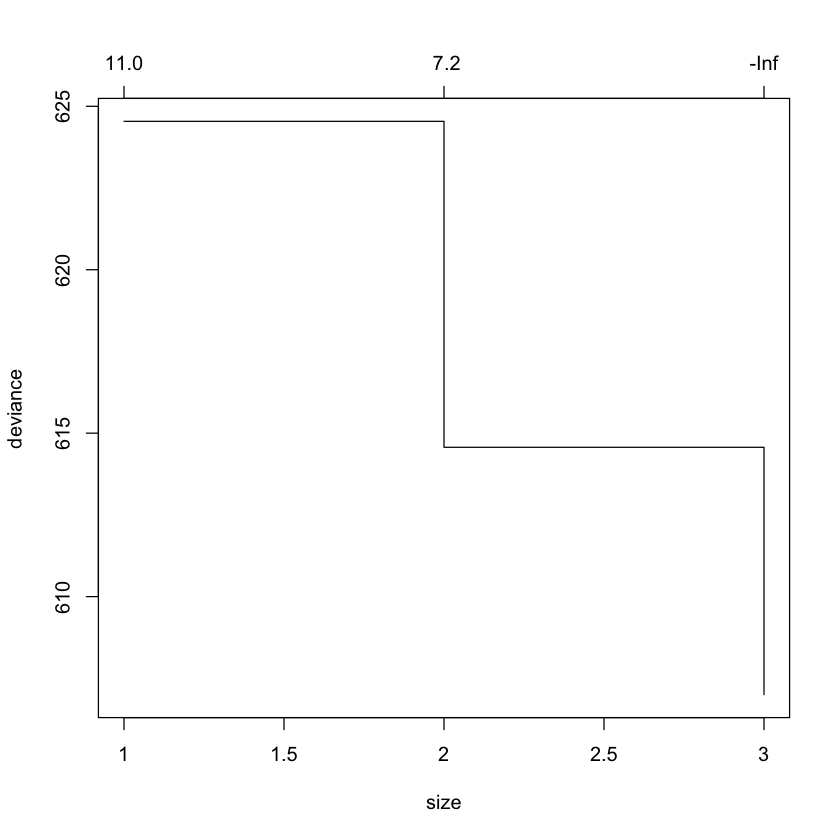

In [16]:
prot.cvtree = cv.tree(prot.tree) 
plot(prot.cvtree)
cat("Size corresponding to minimum deviance by cross-validation:", prot.cvtree$size[which.min(prot.cvtree$dev)])

Testing accuracy 75.1503 %
Testing accuracy 76.68958 %


Regression tree:
snip.tree(tree = prot.tree, nodes = 2L)
Variables actually used in tree construction:
[1] "SER"
Number of terminal nodes:  2 
Residual mean deviance:  0.1756 = 613 / 3490 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.2581 -0.2581 -0.2581  0.0000 -0.1041  0.8959 

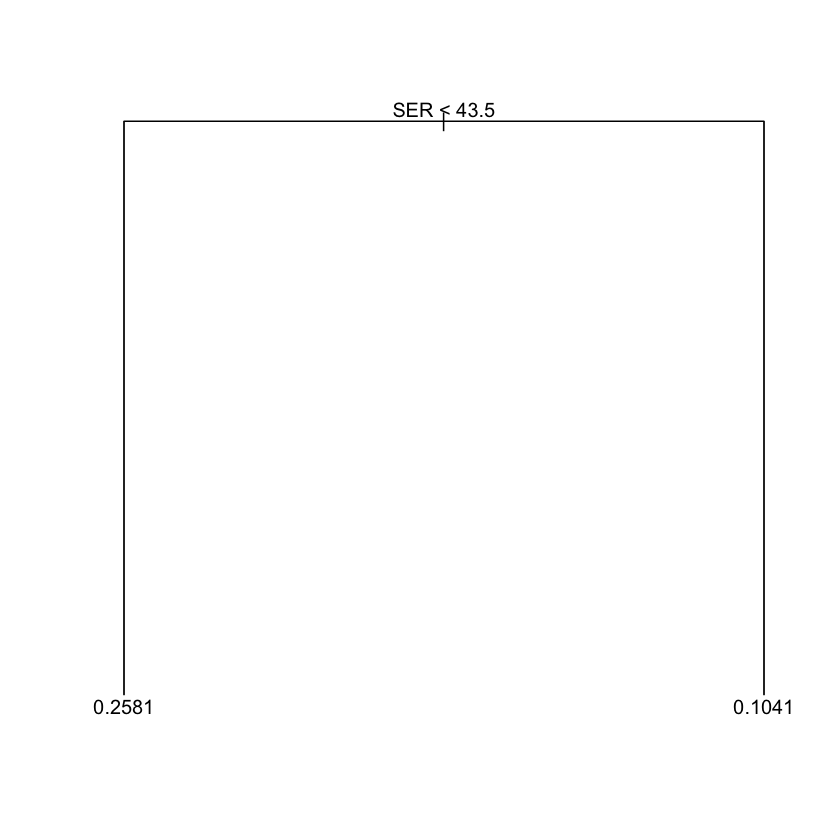

In [17]:
prot.pruned_tree =  prune.tree(prot.tree, best = 2)
cat('Testing accuracy', 100*sum(round(predict(prot.pruned_tree, dat.test),0)==dat.test[j])/nrow(dat.test), '%\n')
cat('Testing accuracy', 100*sum(round(predict(prot.pruned_tree, dat.train),0)==dat.train[j])/nrow(dat.train), '%')
summary(prot.pruned_tree)
plot(prot.pruned_tree)
text(prot.pruned_tree)

We can see that the performance immediately dropped when we removed the feature `OLIG_COUNT`. Moreover pruning the tree didn't even change the accuracy. 